Team Gordon

Student Name	Student Number
 Alisha Sahota	20497348
 Anthony Ramelo	20499391
 Chris Wu	10182394
 Elizabeth Zhang	20161231
 Emily Zhao	10096273
 Sam Hossain	20466500


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

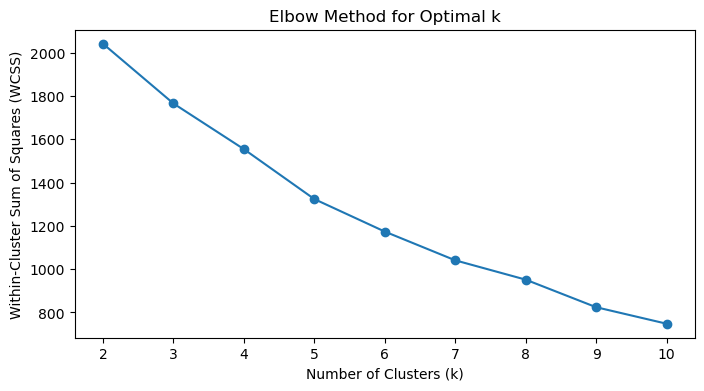

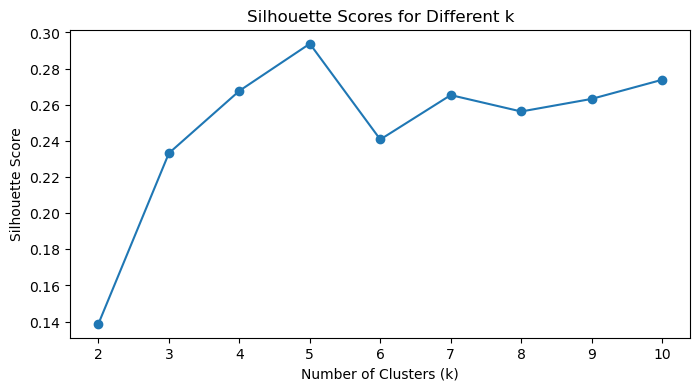

For n_clusters = 2, Silhouette Score = 0.1388126943177033
For n_clusters = 3, Silhouette Score = 0.23317432478500777
For n_clusters = 4, Silhouette Score = 0.26766010890103825
For n_clusters = 5, Silhouette Score = 0.2937300362346193
For n_clusters = 6, Silhouette Score = 0.2407466331326706
For n_clusters = 7, Silhouette Score = 0.26531088422134297
For n_clusters = 8, Silhouette Score = 0.2562317254435246
For n_clusters = 9, Silhouette Score = 0.26319656269068276
For n_clusters = 10, Silhouette Score = 0.27377354313877555


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


TypeError: agg function failed [how->mean,dtype->object]

In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# For dimensionality reduction
from sklearn.decomposition import PCA

# For clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ==========================
# Load the Data
# ==========================

# Load the data
dfcrosssection = pd.read_excel('Data 3 - October, 2024.xlsx', sheet_name='Parachute - Cross Section')

# Save the ID column separately for reference
dfcrosssection['ID'] = dfcrosssection['ID'].astype(str)
ids = dfcrosssection['ID']

# List of columns to remove
columns_to_remove = list(set([
    "Aptitude for change Score",
    "Financial Literacy Score",
    "Self Assessments",
    "Quiz Count",
    "Mood Count",
    "Inspiration Count",
    "Total Activies",
    "Average total activities per month",
    "Average activities per day",
    "Loan Amount",
    "Disbursement Date",
    "Province",
    "Loan Payment Type",
    "Loan Maturity Date",
    "Weekly Activity Count",
    "Monthly Activity Count",
    "City",
    "Postal Code",
    "Loan Term (Months)",
    "Date of Birth",
    "Stated Income on application",
    "ID"  # Exclude ID from clustering computations
]))

# Remove unnecessary columns
dfcrosssection = dfcrosssection.drop(columns=columns_to_remove, errors='ignore')

# ==========================
# Data Preprocessing
# ==========================

# Drop columns with more than 50% missing values
threshold = len(dfcrosssection) * 0.5
dfcrosssection = dfcrosssection.dropna(thresh=threshold, axis=1)

# Handle missing values for numerical columns
numeric_cols = dfcrosssection.select_dtypes(include=['float64', 'int64']).columns
imputer_num = SimpleImputer(strategy='mean')
dfcrosssection[numeric_cols] = imputer_num.fit_transform(dfcrosssection[numeric_cols])

# Handle missing values for categorical columns
categorical_cols = dfcrosssection.select_dtypes(include=['object']).columns
imputer_cat = SimpleImputer(strategy='most_frequent')
dfcrosssection[categorical_cols] = imputer_cat.fit_transform(dfcrosssection[categorical_cols])

# Encode categorical variables
df_encoded = pd.get_dummies(dfcrosssection, columns=categorical_cols, drop_first=True)

# Scale the features
features_to_scale = df_encoded.columns
scaler = StandardScaler()
df_encoded[features_to_scale] = scaler.fit_transform(df_encoded[features_to_scale])

# ==========================
# Dimensionality Reduction using PCA
# ==========================

# Apply PCA to retain 90% of the variance
pca = PCA(n_components=0.9, random_state=42)
principal_components = pca.fit_transform(df_encoded)

# Create a DataFrame with principal components
df_pca = pd.DataFrame(data=principal_components)

# ==========================
# Determining the Optimal Number of Clusters
# ==========================

wcss = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)
    wcss.append(kmeans.inertia_)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(df_pca, labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(K, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(K)
plt.show()

# Plot the Silhouette Scores
plt.figure(figsize=(8, 4))
plt.plot(K, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(K)
plt.show()

# Print silhouette scores for all k values
for k, score in zip(K, silhouette_scores):
    print(f"For n_clusters = {k}, Silhouette Score = {score}")

# Choose the optimal number of clusters based on the plots
optimal_k = 4  # Update this number based on your analysis

# ==========================
# Clustering
# ==========================

# Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_encoded['Cluster'] = kmeans.fit_predict(df_pca)

# Add the cluster labels and ID back to the original DataFrame
dfcrosssection['Cluster'] = df_encoded['Cluster']
dfcrosssection['ID'] = ids

# ==========================
# Analysis and Visualization
# ==========================

# Analyze cluster profiles for numeric columns
cluster_profiles_numeric = dfcrosssection.groupby('Cluster').mean()

# Analyze cluster profiles for categorical columns
categorical_cols = dfcrosssection.select_dtypes(include=['object']).columns
def mode_function(x):
    return x.mode().iloc[0] if not x.mode().empty else np.nan

cluster_profiles_categorical = dfcrosssection.groupby('Cluster')[categorical_cols].agg(mode_function)

# Combine numeric and categorical summaries
cluster_profiles = pd.concat([cluster_profiles_numeric, cluster_profiles_categorical], axis=1)
print("Cluster Profiles:\n", cluster_profiles)

# Visualize clusters in 2D using the first two principal components
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_pca.iloc[:, 0],
    df_pca.iloc[:, 1],
    c=df_encoded['Cluster'],
    cmap='viridis',
    alpha=0.6,
)
plt.title('Customer Segments')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

# ==========================
# Evaluation
# ==========================

# Compute the silhouette score for the chosen k
silhouette_avg = silhouette_score(df_pca, df_encoded['Cluster'])
print(f"Silhouette Score for k={optimal_k}: {silhouette_avg}")

# ==========================
# Save the Segmented Data
# ==========================

# Save the DataFrame with cluster assignments to a CSV file
dfcrosssection.to_csv('segmented_customers.csv', index=False)